After running into some issues with installing basemap using conda and python 3.5, I have switched to python 2.7 for plotting purposes.

Basemap is a matplotlib extention that adds geographical projects and some datasets to be able to plot coast lines, countries and so on directly from the library.

## Sea ice concentration on a polar stereographic projection

I downloaded the NOAA/NSIDC CDR monthly mean SIC product ([Meier et al., 2013](http://dx.doi.org/10.7265/N55M63M1)). This data set provides a Climate Data Record (CDR) of sea ice concentration from passive microwave data with consistent, daily and monthly time series of sea ice concentrations from 09 July 1987 through the most recent processing for both the north and south polar regions on a 25 km x 25 km polar stereographic grid. 

Meier, W., F. Fetterer, M. Savoie, S. Mallory, R. Duerr, and J. Stroeve. 2013, updated 2015. NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 2. [monthly]. Boulder, Colorado USA. NSIDC: National Snow and Ice Data Center. doi: http://dx.doi.org/10.7265/N55M63M1. [11 August, 2016].


In [7]:
import numpy
from netCDF4 import Dataset # use Dataset to unpack netcdf data
from matplotlib import pyplot
from mpl_toolkits.basemap import Basemap

# magic function to make matplotlib inline; other style specs must come after
%matplotlib inline

In [8]:
seaicefile = 'data/seaice_conc_monthly_sh_f17_201408_v02r00.nc'
fh = Dataset(seaicefile, mode='r')

Check which variables are in the file:

In [9]:
vars = fh.variables.keys()
for i in vars:
    print(i)

projection
seaice_conc_monthly_cdr
stdev_of_seaice_conc_monthly_cdr
melt_onset_day_seaice_conc_monthly_cdr
qa_of_seaice_conc_monthly_cdr
goddard_merged_seaice_conc_monthly
goddard_nt_seaice_conc_monthly
goddard_bt_seaice_conc_monthly
time
ygrid
xgrid
latitude
longitude


I got the following ncdump function from [Chris Slocum](http://schubert.atmos.colostate.edu/~cslocum/netcdf_example.html). There are more examples on using NetCDF and Python at the Unidata NetCDF [example](http://www.unidata.ucar.edu/software/netcdf/examples/programs/) programs page.

In [10]:
def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print "\t\ttype:", repr(nc_fid.variables[key].dtype)
            for ncattr in nc_fid.variables[key].ncattrs():
                print '\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr))
        except KeyError:
            print "\t\tWARNING: %s does not contain variable attributes" % key

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print "NetCDF Global Attributes:"
        for nc_attr in nc_attrs:
            print '\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print "NetCDF dimension information:"
        for dim in nc_dims:
            print "\tName:", dim 
            print "\t\tsize:", len(nc_fid.dimensions[dim])
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print "NetCDF variable information:"
        for var in nc_vars:
            if var not in nc_dims:
                print '\tName:', var
                print "\t\tdimensions:", nc_fid.variables[var].dimensions
                print "\t\tsize:", nc_fid.variables[var].size
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [11]:
nc_attrs, nc_dims, nc_vars = ncdump(fh)

NetCDF Global Attributes:
	Conventions: u'CF-1.6'
	title: u'NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration'
	references: u'Comiso, J. C., and F. Nishio. 2008. Trends in the Sea Ice Cover Using Enhanced and Compatible AMSR-E, SSM/I, and SMMR Data. Journal of Geophysical Research 113, C02S07, doi:10.1029/2007JC0043257. ; Comiso, J. C., D. Cavalieri, C. Parkinson, and P. Gloersen. 1997. Passive Microwave Algorithms for Sea Ice Concentrations: A Comparison of Two Techniques. Remote Sensing of the Environment 60(3):357-84. ; Comiso, J. C. 1984. Characteristics of Winter Sea Ice from Satellite Multispectral Microwave Observations. Journal of Geophysical Research 91(C1):975-94. ; Cavalieri, D. J., P. Gloersen, and W. J. Campbell. 1984. Determination of Sea Ice Parameters with the NIMBUS-7 SMMR. Journal of Geophysical Research 89(D4):5355-5369. ; Cavalieri, D. J., C. l. Parkinson, P. Gloersen, J. C. Comiso, and H. J. Zwally. 1999. Deriving Long-term Time Series of Se

In [12]:
# extract the variables that we want to use:

lons = fh.variables['longitude'][:]
lats = fh.variables['latitude'][:]
#time = fh.variables['time'][:]
#xgrid = fh.variables['xgrid'][:]
#ygrid = fh.variables['ygrid'][:]
sic = fh.variables['seaice_conc_monthly_cdr'][:]
sic2 = fh.variables['goddard_merged_seaice_conc_monthly'][:]
#proj = fh.variables['projection'][:]

In [13]:
# close the file

fh.close()

Mask areas with no sea ice cover (i.e. sic <= 0.0) using [numpy.ma](http://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html) (see link for many masking options).

In [14]:
import numpy.ma
sic_masked = numpy.ma.masked_less_equal(sic, 0.0)
sic_masked2 = numpy.ma.masked_less_equal(sic2, 0.0)

### Some notes on basemap settings

**NB** 'm' is used to signify map. 

All maps have a projection. The projection argument set the map projection to be used and many projections require extra arguments. For more information on available projections see http://matplotlib.org/basemap/users/mapsetup.html
The projection `spstere` provides the south pole aspect of the stereographic conformal projection:
* longitude `lon_0` is at 6-o'clock
* latitude circle `boundinglat` is tangent to the edge of the map at lon_0
* default value of `lat_ts` (latitude of ture scale) is pole.

Resolution options are 'c' = crude, 'l' = low, 'i' = intermediate, 'h' = high, 'f' = full or None. None is a good option if a Shapefile will be used.

Matplotlib [colormap](http://matplotlib.org/examples/color/colormaps_reference.html) options can all be reversed by adding "_r".

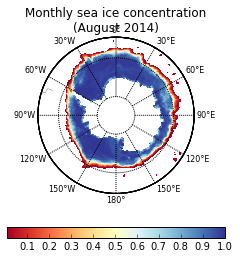

In [17]:
m = Basemap(projection='spstere', boundinglat=-50, lon_0=180., resolution='l', round=True)

#m.bluemarble(alpha = 0.9) # NASA Blue Marble image as map backgrouond
#m.etopo(alpha = 0.5) # etopo relief image as map background
#m.shadedrelief(alpha = 0.5) # shaded relief image as map background
#m.drawlsmask(land_color='coral', ocean_color='aqua',lakes=True) # high resolution land-sea mask 
#m.warpimage() #arbitrary image as map background (image must be global, covering the world in lat.lon coords from the international dateline eastward and the South Pole northward)

m.drawcountries(linewidth=0.25)

m.drawmeridians(numpy.arange(0., 360., 30.),labels=[1,1,1,1],fontsize=8)#,labelstyle='+/-',fmt='%i')
m.drawparallels(numpy.arange(-180., 0., 30.),labels=[0,1,1,0])
m.pcolormesh(lons, lats, sic_masked[0,:,:], cmap='RdYlBu',latlon=True)

pyplot.title('Monthly sea ice concentration\n(August 2014)')
pyplot.colorbar(orientation='horizontal', shrink=0.65)


Next I plotted the same data as a function of longitude and month (2014). 
**Note:** This is not finished - I wanted to try to reproduce something along the lines of fig 2 in [Hobbs et al., 2016](http://www.sciencedirect.com/science/article/pii/S0921818116300364), but still need to work out the pre-processing.

In [9]:
# open container for all monthly files
sic_year = []

for i in range(12):
    num = str(i+1)
    if len(num)<2:
        num='0'+num
    #print num
    seaicefile = 'data/seaice_conc_monthly_sh_f17_2014'+num+'_v02r00.nc'
    #print seaicefile
    
    fh = Dataset(seaicefile, mode='r')
    sicm = fh.variables['seaice_conc_monthly_cdr'][:]
    if i == 0:
        lons = fh.variables['longitude'][:]
        lats = fh.variables['latitude'][:]
        sic_year = sicm
    else:
        sic_year = numpy.vstack((sic_year,sicm))
    fh.close()

In [17]:
print(sic_year.shape)
sic_year = numpy.ma.masked_less_equal(sic_year, 0.0)
print(lons.shape)
print(lats.shape)
print(lats[:10,0])
print(lats[0,:10])
print(lats[:4,:4])
print(lons[:4,:4])

(12L, 332L, 316L)
(332L, 316L)
(332L, 316L)
[-39.36486911 -39.50529733 -39.64551372 -39.78551336 -39.92529126
 -40.06484238 -40.20416165 -40.34324393 -40.48208404 -40.62067676]
[-39.36486911 -39.49228444 -39.61938141 -39.74615466 -39.87259878
 -39.99870833 -40.12447782 -40.24990171 -40.37497443 -40.49969039]
[[-39.36486911 -39.49228444 -39.61938141 -39.74615466]
 [-39.50529733 -39.6332616  -39.76090862 -39.88823299]
 [-39.64551372 -39.77402885 -39.90222784 -40.0301053 ]
 [-39.78551336 -39.91458122 -40.04333412 -40.17176661]]
[[-42.23256961 -42.05100608 -41.86839864 -41.68474199]
 [-42.3974378  -42.21577271 -42.03305644 -41.84928359]
 [-42.56335175 -42.38159053 -42.19877084 -42.01488716]
 [-42.73031865 -42.54846683 -42.36554924 -42.18156022]]
